# Challenge

This challenge is designed to increase difficulty gradually. First, we will start by gaining some intuition about the different steps of the problem by looking at different circuits and topologies of 5-qubit chips. As the final part of the challenge, we will guide you to design your own routing algorithm.

## Warm up - GHZ state on star topology

In Qilimanjaro, we have access to a 5-qubit digital chip with a star topology (FIG.1). In this topology, all two-qubit gates need to be implemented using the central qubit as a mediator. You can start by considering that the central qubit is bidireccional, i.e., it can be used as a control or target qubit. 

<p style="text-align: center"><img src="https://i.imgur.com/tVLBLaG.png" width=400 /></p>

*FIG.1: Star topology with 5 qubits.*

As a first step, we will generate a state of particular importance for quantum computation and physics, the Greenberger–Horne–Zeilinger (GHZ) state.   The GHZ state is a maximally entangled state, meaning that the qubits are highly correlated with each other and therefore, any measurement on one qubit will instantaneously affect the state of the other qubits. The GHZ state is a superposition of all qubits being in the state $|0\rangle$ and all qubits being in the state $|1\rangle$ and it is generated by the following circuit (FIG.2).

## IMPORTS:

In [1]:
import matplotlib.pyplot as plt
from qibo import gates, models

from helper_functions import *
from GraphUtils import *


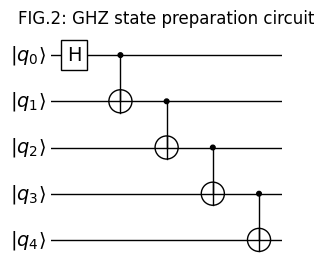

In [2]:
from qibo.ui import plot_circuit
from qibo import gates, models

ghz_c = models.Circuit(5)

ghz_c.add(gates.H(0))
ghz_c.add(gates.CNOT(0, 1))
ghz_c.add(gates.CNOT(1, 2))
ghz_c.add(gates.CNOT(2, 3))
ghz_c.add(gates.CNOT(3, 4))

ax, fig = plot_circuit(ghz_c)
ax.set_title("FIG.2: GHZ state preparation circuit")
plt.show()


In [3]:
# Execute the circuit with the default initial state |00000>.
result = ghz_c(nshots=1)
print(result)

[Qibo 0.2.12|ERROR|2024-10-09 13:51:37]: The 'qibojit' backends' provider is not available. Check that a Python package named 'qibojit' is installed, and it is exposing valid Qibo backends.
[Qibo 0.2.12|ERROR|2024-10-09 13:51:37]: The 'qibojit' backends' provider is not available. Check that a Python package named 'qibojit' is installed, and it is exposing valid Qibo backends.
[Qibo 0.2.12|INFO|2024-10-09 13:51:37]: Using numpy backend on /CPU:0


(0.70711+0j)|00000> + (0.70711+0j)|11111>


### Question
Considering a the star topology of FIG.1, can you implement the GHZ preparation circuit with the necessary SWAPS to implement it?

Final layout: {'q0': 0, 'q1': 2, 'q2': 3, 'q3': 1, 'q4': 4}


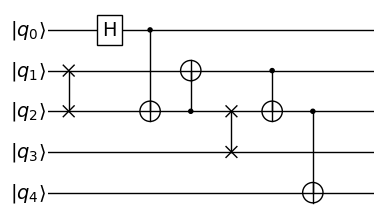

In [4]:
ghz_routed_c, ghz_routed_layout = transpile_to_star_connectivity(
    ghz_c, initial_map={"q0": 0, "q1": 1, "q2": 2, "q3": 3, "q4": 4}, sabre=True
)

plot_transpiled_circuit(ghz_routed_c, ghz_routed_layout)

## Exercise 1

Now consider the circuit from FIG.2. Your mission is to implement this circuit in the star topology by following the steps below:
1. Divide the circuit into timeslices.
2. Determine the initial placement of the qubits such that the maximum number of two-qubit gates can be implemented without SWAPS. This may not be trivial to see so you can always try a random placement, the only problem is that you will have to implement more SWAPS, which is the metric we want to minimize throughout the challenge.
3. Once the initial placement is defined, how many extra SWAPS do you need to implement the circuit? 
4. Now imagine that the central qubit is unidirectional (the case of real quantum hardware), i.e., it can only be used as a control qubit. How much does the depth of the circuit increase in this case?
5. Is there any trivial gate cancellation that can be done to reduce the depth of the circuit? (i.e. two CNOTs in sequence are just the identity. Same with two contiguous Hadamards).
6. Give a method to verify that your resulting circuit represents the same unitary as the original one, i.e. both circuits are equivalent.

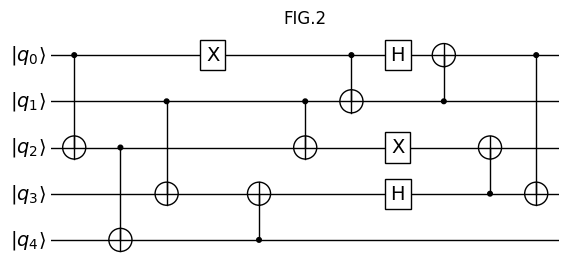

In [5]:
from qibo.ui import plot_circuit

c = models.Circuit(5)
c.add(gates.CNOT(0, 2))
c.add(gates.CNOT(2, 4))
c.add(gates.CNOT(1, 3))
c.add(gates.X(0))
c.add(gates.CNOT(4, 3))
c.add(gates.CNOT(1, 2))
c.add(gates.CNOT(0, 1))
c.add(gates.X(2))
c.add(gates.H(0))
c.add(gates.H(3))
c.add(gates.CNOT(1, 0))
c.add(gates.CNOT(3, 2))
c.add(gates.CNOT(0, 3))
ax, fig = plot_circuit(c)
ax.set_title("FIG.2")
plt.show()

## Answers:
2. Trivial mapping seems optimal
3. 2 SWAPS are required later on, with a kind of smart diagonal SWAP, from q2 to q3, we obtain the next circuit:

Depth of circuit:  13


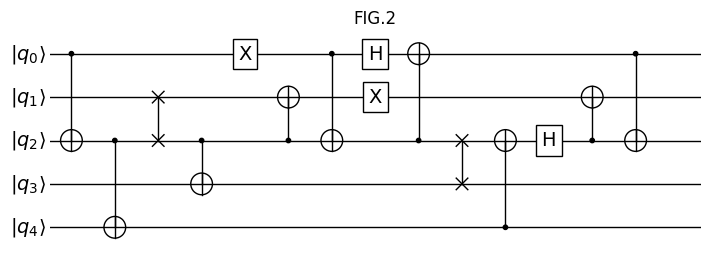

In [6]:
from qibo.ui import plot_circuit

routed_c = models.Circuit(5)
routed_c.add(gates.CNOT(0, 2))
routed_c.add(gates.CNOT(2, 4))
routed_c.add(gates.SWAP(1, 2))
routed_c.add(gates.CNOT(2, 3))
routed_c.add(gates.X(0))
routed_c.add(gates.CNOT(2, 1))
routed_c.add(gates.CNOT(0, 2))
routed_c.add(gates.X(1))
routed_c.add(gates.H(0))
routed_c.add(gates.CNOT(2, 0))
routed_c.add(gates.SWAP(2, 3))
routed_c.add(gates.CNOT(4, 2))
routed_c.add(gates.H(2))
routed_c.add(gates.CNOT(2, 1))
routed_c.add(gates.CNOT(0, 2))

ax, fig = plot_circuit(routed_c)
ax.set_title("FIG.2")
print("Depth of circuit: ", routed_c.depth)
plt.show()

4. If qubit 2, can only interact as control, then our circuit becomes:

Depth of circuit:  33


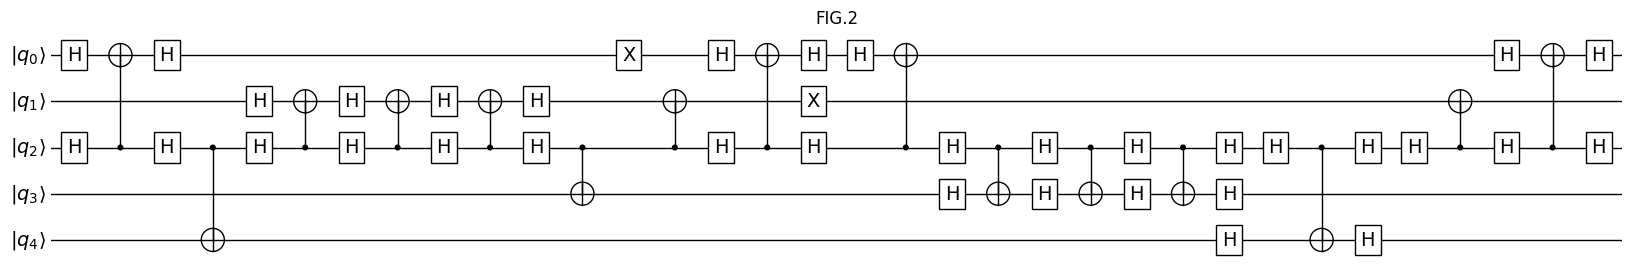

In [7]:
def add_reversed_CNOT_in_correct_order(c, control_qubit, target_qubit):
    c.add(gates.H(target_qubit))
    c.add(gates.H(control_qubit))
    c.add(gates.CNOT(control_qubit, target_qubit))
    c.add(gates.H(target_qubit))
    c.add(gates.H(control_qubit))


def add_SWAP_as_directional_CNOTs(c, control_qubit, target_qubit):
    c.add(gates.H(target_qubit))
    c.add(gates.H(control_qubit))
    c.add(gates.CNOT(control_qubit, target_qubit))
    c.add(gates.H(target_qubit))
    c.add(gates.H(control_qubit))
    c.add(gates.CNOT(control_qubit, target_qubit))
    c.add(gates.H(target_qubit))
    c.add(gates.H(control_qubit))
    c.add(gates.CNOT(control_qubit, target_qubit))
    c.add(gates.H(target_qubit))
    c.add(gates.H(control_qubit))


directional_c = models.Circuit(5)

# First direction change
add_reversed_CNOT_in_correct_order(directional_c, 2, 0)

directional_c.add(gates.CNOT(2, 4))

# First SWAP into CNOT with correct direction:
add_SWAP_as_directional_CNOTs(directional_c, 2, 1)

directional_c.add(gates.CNOT(2, 3))
directional_c.add(gates.X(0))
directional_c.add(gates.CNOT(2, 1))

# Second direction change
add_reversed_CNOT_in_correct_order(directional_c, 2, 0)

directional_c.add(gates.X(1))
directional_c.add(gates.H(0))
directional_c.add(gates.CNOT(2, 0))

# Second SWAP into CNOT with correct direction:
add_SWAP_as_directional_CNOTs(directional_c, 2, 3)

# Third direction change
add_reversed_CNOT_in_correct_order(directional_c, 2, 4)

directional_c.add(gates.H(2))
directional_c.add(gates.CNOT(2, 1))

# Last direction change
add_reversed_CNOT_in_correct_order(directional_c, 2, 0)


ax, fig = plot_circuit(directional_c)
ax.set_title("FIG.2")
print("Depth of circuit: ", directional_c.depth)
plt.show()

5. But of course, this can be optimized, with the suggested cancelations (HH=I), where from visual inspection, we see we can at least cancel 3 pairs of H's..., and reducing the depth by 3, to 30! (everypair, also has some one qubit gate under it, making it only reduce 1 depth, and not 2... sadly)

6. To show that the circuits are the same, we are gonna compare the distance between their final unitary matrices!

But for that, we will need to reorder back, how the qubits positions end... Here we do that:

In [8]:
# Check we can find the final reordering needed:
print(ghz_routed_layout)
print(find_final_reordering(ghz_routed_c, ghz_routed_layout))

print("\n")
# Check we can find the final reordering needed:
routed_layout = {"q0": 0, "q1": 1, "q2": 2, "q3": 3, "q4": 4}  # It was the trivial layout
print(routed_layout)
print(find_final_reordering(routed_c, routed_layout))

{'q0': 0, 'q1': 2, 'q2': 3, 'q3': 1, 'q4': 4}
{'q0': 0, 'q1': 2, 'q2': 3, 'q3': 1, 'q4': 4}


{'q0': 0, 'q1': 1, 'q2': 2, 'q3': 3, 'q4': 4}
{'q0': 0, 'q1': 1, 'q2': 2, 'q3': 3, 'q4': 4}


And now that we have the final_reordering dict, we can do:

In [24]:
import numpy as np

from qibo import models, gates

from copy import deepcopy


# TODO: FIX equivelance function!
def circuits_equivalence_fidelity(og_circuit, transp_circuit, layout):
    """Check if two circuits are equivalent.

    Args:
        og_circuit (qibo.models.Circuit): Original circuit to compare.
        transp_circuit (qibo.models.Circuit): Transpiler circuit to compare.
        layout (dict): Layout used for the transpiled circuit.

    Returns:
        float: Fidelity between the two circuits.
    """
    reordering = find_final_reordering(transp_circuit, layout)

    circuit_2_copy = deepcopy(transp_circuit)

    # Block to mix the initial layout, with the SWAPS in the circuit
    while True:
        end = True
        for k, v in reordering.items():
            if int(k[1:]) != v:
                circuit_2_copy.add(gates.SWAP(int(k[1:]), v))
                swap_count_circuit = models.Circuit(circuit_2_copy.nqubits)
                swap_count_circuit.add(gates.SWAP(int(k[1:]), v))
                reordering = find_final_reordering(swap_count_circuit, reordering)
                end = False
                break
        if end:
            break

    U1 = og_circuit.unitary()
    U2 = circuit_2_copy.unitary()
    almost_identity = U1.transpose().conjugate() @ U2
    trace = np.trace(almost_identity)
    normalized = np.abs(trace) / (2**og_circuit.nqubits)
    return normalized**2

In [10]:
# circuits_equivalence_fidelity(ghz_c, ghz_routed_c, ghz_routed_layout)

In [11]:
# circuits_equivalence_fidelity(c, routed_c, {"q0": 0, "q1": 1, "q2": 2, "q3": 3, "q4": 4})

# Using Qibo own layout and routing algorithms:

## With Start connectivity Layour & Routing:

Final layout: {'q0': 0, 'q1': 1, 'q2': 3, 'q3': 2, 'q4': 4}


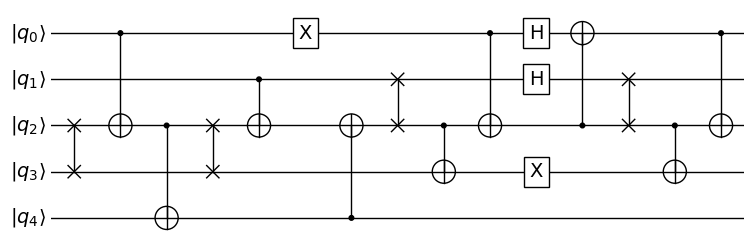

In [12]:
transpiled_c, final_c_layout = transpile_to_star_connectivity(c)

plot_transpiled_circuit(transpiled_c, final_c_layout)
# print("Transpilation Fidelity: ", circuits_equivalence_fidelity(c, transpiled_c, final_c_layout))


## With custom Layout:

Final layout: {'q0': 0, 'q1': 1, 'q2': 3, 'q3': 2, 'q4': 4}


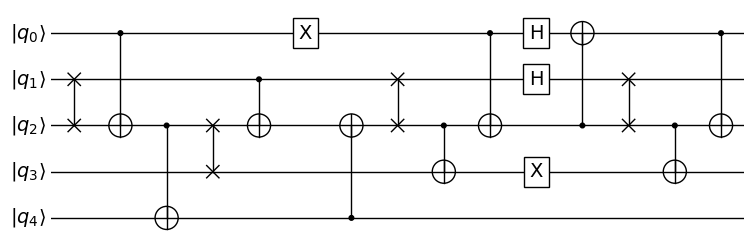

In [13]:
transpiled_c, final_c_layout = transpile_to_star_connectivity(c, initial_map={0: 0, 1: 2, 2: 1, 3: 3, 4: 4})

plot_transpiled_circuit(transpiled_c, final_c_layout)
# print("Transpilation Fidelity: ", circuits_equivalence_fidelity(c, transpiled_c, final_c_layout))

## With SABRE Routing and custom initial Layout:

Final layout: {'q0': 0, 'q1': 2, 'q2': 3, 'q3': 1, 'q4': 4}


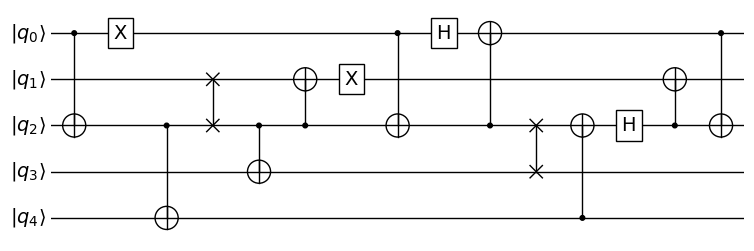

In [14]:
transpiled_c, final_c_layout = transpile_to_star_connectivity(
    c, initial_map={"q0": 0, "q1": 1, "q2": 2, "q3": 3, "q4": 4}, sabre=True
)

# TODO: ERROR ON QIBO mapping (RAISE AN ISSUE)
# transpiled_c, final_c_layout = transpile_to_star_connectivity(c, initial_map={0: 0, 1: 1, 2: 2, 3: 3, 4: 4}, sabre=True)

plot_transpiled_circuit(transpiled_c, final_c_layout)
# print("Transpilation Fidelity: ", circuits_equivalence_fidelity(c, transpiled_c, final_c_layout))

### Since we see, that depending on the executions, we get 2 or 3 SWAP gates, we will do an interator, that tries several times, and keeps the best result:

### With Sabre:

Final layout: {'q0': 3, 'q1': 1, 'q2': 0, 'q3': 2, 'q4': 4}


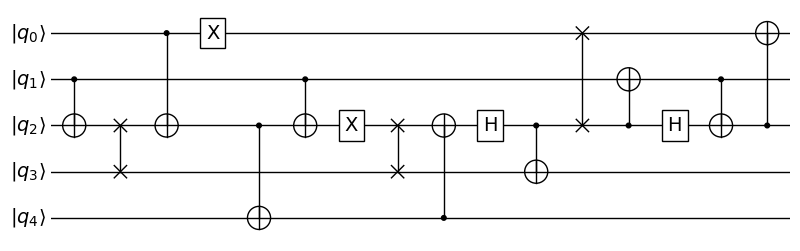

In [15]:
transpiled_c, final_c_layout = find_best_routing(
    c,
    sabre=True,
    transpiler_fun=transpile_to_star_connectivity,
    iterations=100,
)

plot_transpiled_circuit(transpiled_c, final_c_layout)
# print("Transpilation Fidelity: ", circuits_equivalence_fidelity(c, transpiled_c, final_c_layout))

## Exercise 2

Consider now the following topologies for a 5-qubit chip: the T-topology (FIG.3) and the chain topology (FIG.4). Follow the previous steps and compare the number of SWAPS needed to implement the circuit from FIG.2 in these two topologies. What conclusions can you draw from this comparison?

<p style="text-align: center"><img src="https://i.imgur.com/6SeZYmO.png" width=400 /></p>


*FIG.3: T-topology with 5 qubits*

<p style="text-align: center"><img src="https://i.imgur.com/vKNOWlh.png" width=400 /></p>

*FIG.4: Chain topology with 5 qubits*

## Exercise 3 

In real hardware, we have a fixed topology and a rich variety of circuits, with different connectivies and so on. Most likely the circuit executable will not be directly mappable to the topology of the hardware. It is imperative to have a compilation procedure that, among other tasks, deals with the qubit routing. In this exercise, we will design our own algorithm for qubit routing, beware that this is not a trivial task! 

The algorithm proceeds in four stages: decomposing the input circuit into timesteps; determining an initial placement; routing across timesteps; and a final clean-up phase (optional).

We will design the qubit routing algorithm using a brand new circuit (FIG.5) on the star-topology (FIG.1) but, once finished, we can test it on the circuits and topologies from the previous exercises. 

#### Check this paper, for more info on the algorithm: https://arxiv.org/pdf/2003.10611

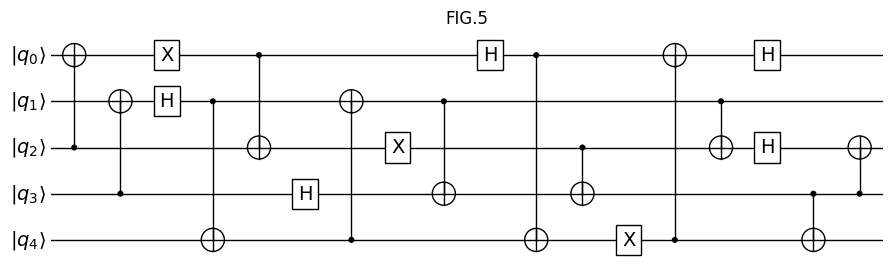

In [16]:
import matplotlib.pyplot as plt
from qibo import gates, models
from qibo.ui import plot_circuit

c = models.Circuit(5)
c.add(gates.CNOT(2, 0))
c.add(gates.CNOT(3, 1))
c.add(gates.X(0))
c.add(gates.H(1))
c.add(gates.CNOT(1, 4))
c.add(gates.CNOT(0, 2))
c.add(gates.H(3))
c.add(gates.CNOT(4, 1))
c.add(gates.X(2))
c.add(gates.CNOT(1, 3))
c.add(gates.H(0))
c.add(gates.CNOT(0, 4))
c.add(gates.CNOT(2, 3))
c.add(gates.X(4))
c.add(gates.CNOT(4, 0))
c.add(gates.CNOT(1, 2))
c.add(gates.H(2))
c.add(gates.H(0))
c.add(gates.CNOT(3, 4))
c.add(gates.CNOT(3, 2))
ax, fig = plot_circuit(c)
ax.set_title("FIG.5")
plt.show()

### A. Slicing the circuit into timesteps

Before routing we partition the quantum circuit into timesteps. The circuit structure provides a
natural partial ordering of the gates; thus a greedy algorithm starting from inputs can divide the input circuit into “horizontal” partitions of gates which can be executed simultaneously. We simply traverse the circuit adding the qubits involved in a 2-qubit gate to the current timestep. Since only multiqubit interactions (such as CNOT or CZ gates) constrain the problem, single qubit gates can be ignored (fMore accurately: while the single qubit gates can be ignored for the purposes of routing, they must be retained for circuit generation; for clarity we ignore them for now).

If a gate requires a qubit already used in the previous timestep, a new timestep is created. This procedure is repeated until all gates are assigned to a timestep. A timestep thus consists of a set of disjoint pairs of (virtual) qubits which represent gates scheduled for simultaneous execution.

#### Q1. Can you obtain the timesteps for the circuit of FIG.2? 

Write the timesteps in the following format: 

$$\begin{aligned}
&1 \rightarrow \{(q_i, q_j), (q_k, q_l), ...\}  \hspace{4mm} i,j,k,l \in \{0,1,2,3,4\}\\
&2 \rightarrow \{(...), ...\}\\
&3 \rightarrow \{(...),...\}\\
&4 \rightarrow \{(...),...\}\\
\end{aligned}$$

Timesteps is a list of lenght $T$ with $T$ being the total number of timesteps.  At time step $t \in [0,T-1]$, we find $L$ tuples, with $L$ being the total number of interactions. There is a tuple for each interaction between qubit $i$ and $j$, with $i\neq j$. For the circuit tutorial, you can just type it manually.

As an example, the timesteps for the tutorial circuit would be ```timesteps = [[(0,2), (1,3)], [(1,2)], [(0,1)], [(0,1), (2,3)]]```

In [17]:
timesteps = [[(...), (...)], [(...), (...)]]

 **BONUS.** To generalize the algorithm, write a ```function``` that takes as input a circuit (or a list of gates per qubit) and outputs the timesteps. Skip this step and only do it when you have completed exercises B and C. You will only need this function if you want to test random extra circuits.

In [18]:
from qibo import gates, models
from typing import List, Dict, Tuple


def generate_timesteps(circuit: models.Circuit) -> List[List[gates.Gate]]:
    """
    Function to determine the timesteps of a given circuit

    Args:
    circuit (Qibo circuit): qibo circuit to determine the timesteps

    Returns:
    timesteps (list): list of timesteps with the qubits involved in each timestep
    """

    circuit_gates: List[gates.Gate] = circuit.queue

    timesteps: List[List[gates.Gate]] = []
    current_timestep: List[gates.Gate] = []

    qubits_used_in_current_timestep = []

    for gate in circuit_gates:
        if gate.qubits[0] in qubits_used_in_current_timestep or (
            len(gate.qubits) > 1 and gate.qubits[1] in qubits_used_in_current_timestep
        ):
            timesteps.append(current_timestep.copy())
            current_timestep = [gate]
            qubits_used_in_current_timestep = [gate.qubits[0]]
        else:
            current_timestep.append(gate)
            qubits_used_in_current_timestep.append(gate.qubits[0])

        if len(gate.qubits) > 1:
            qubits_used_in_current_timestep.append(gate.qubits[1])
    timesteps.append(current_timestep.copy())

    return timesteps

### B. Initial Mapping

For the routing algorithm to proceed we require an initial mapping of virtual qubits (referred to as qubits) and physical qubits (referred to as nodes).

Iterate over the timesteps to construct a graph whose nodes are qubits. At timestep $n$ add the edge $(q, q')$ to the graph if *(i)* this pair is present in the timestep and *(ii)* both qubits $q$ and $q'$ have degrees (num of edged in them) less than 2 in the current graph.  If done correctly, each connected component of the resulting graph is necessarily either a line or a ring; the rings are broken by removing an arbitrarily chosen edge. 

Disconnected qubits in this graph correspond to qubits which never interact at all, or to those whose first interaction is qith a qubit whose first two interactions are with others. You can ignore these disconnected qubits as they are not needed for the initial placement, but they will be added later in the routing procedure. 

Once you have obtained this graph, select a subgraph of the architecture with high average degree and low diameter to start from. It should now be possible to map the qubit graph to the architecture as one long line starting from the a high degree vertex within this subgraph, and greedily choosing the highest degree available neighbor. This ensures that most of the gates in the first two timesteps can be applied without any SWAPS. The only exceptions are those gates corresponding to the edges removed when breaking rings. 

If the initial mapping cannot be completed as one long line, then the line is split and mapped as several line segments.
Program the ```initial_mapping``` function that takes as input the timesteps and outputs the initial mapping as a dictionary
 

In [19]:
from typing import List, Dict, Tuple

STAR_ARCHITECTURE: Dict[int, List[int]] = {0: [1, 2, 3, 4], 1: [0], 2: [0], 3: [0], 4: [0]}


def initial_mapping(timesteps: List[List[gates.Gate]]) -> Dict[int, int]:
    """
    Function to determine the initial mapping of the qubits to the architecture.

    Args:
    timesteps (list): list of timesteps with the qubits involved in each timestep

    Returns:
    dict: dictionary with the initial mapping of virtual qubits (referred to as qubits) to physical qubits (referred to as nodes)
    """

    architecture = STAR_ARCHITECTURE
    graph: Dict[int, List[int]] = {}

    # Generate the graph containing connections from each qubit.
    for step in timesteps:
        for gate in step:
            if len(gate.qubits) < 2:
                continue
            if is_pair_present(graph, gate.qubits[0], gate.qubits[1]):
                continue
            if get_node_edges(graph, gate.qubits[0]) >= 2 or get_node_edges(graph, gate.qubits[1]) >= 2:
                continue
            graph = add_to_graph(graph, gate.qubits[0], gate.qubits[1])

    first_qubit = next(iter(graph.keys()))

    list_of_qubits = [first_qubit]
    next_qubit = graph[first_qubit][0]
    while next_qubit is not None and next_qubit is not first_qubit:
        list_of_qubits.append(next_qubit)
        found = False
        for qubit in graph[next_qubit]:
            if qubit not in list_of_qubits:
                next_qubit = qubit
                found = True
                break

        if not found:
            next_qubit = None

    # Create subgraphs from highest degree node
    subgraphs: List[int] = get_subgraphs(architecture)

    return {qubit: subgraphs.pop(0) for qubit in list_of_qubits}

### C. Routing


The routing algorithm that we want to implement iteratively constructs a new circuit which conforms to the desired architecture, taking the sliced circuit and the current mapping of qubits to nodes as input. 

The algorithm compares the current timestep of the input circuit to the current qubit mapping. If a gate in the current timestep requires a qubit which has not yet been mapped, it is allocated to the nearest available node to its partner. All gates which can be performed in the current mapping - all 1-qubit gates and 2-qubit gates whose operands are connected - are immediately removed from the timestep and added to the output circuit. If this exhausts the current timestep, we advance to the next, otherwise SWAPs must be added. 

You will need to define a distance vector $d(s,m)$ which approximates the number of SWAPs needed to make timestep $s$ executable in the mapping $m$; these vectors need to be ordered pointwise. Let $s_0$ denote the current timestep, $s_1$ for its successor, and so on and write $\sigma \bullet m$ to indicate the action of swap $\sigma$ upon the mapping $m$. You can compute the sequence of sets of candidate SWAPs as follows:
$$\begin{aligned}
&\sum_0 = \mathrm{swaps} (s0)\\
&\sum_{t+1} = \text{argmin}_{\sigma\in\sum_t} d(s_t, \sigma \bullet m)
\end{aligned}$$
where $\mathrm{swaps}(s_0)$ denotes all the pertinent SWAPs available at the inital timestep. The sequence terminates either when $|\sum_t|=1$ or after a predefined cutoff (optional). The selected SWAP is added to the circuit and the mapping is updated accordingly. We now return to the start and continue until the entire input circuit has been consumed. 

As guiding, the pointwise of the distance employed should be strict in the sense that $d(s,m)>d(s,\sigma \bullet m)$ implies that for *all* pairs of qubits ($q,q'$) in $s$, the longest of the shortest paths between any two paired qubits in $\sigma \bullet m$ is not longer than the longest of the shortest paths in $m$. 

In other words, the diameter of the subgraph composed of all pairs of qubits ($q,q'$) in $s$ should decrease strictly under the action of $\mathrm{swap}$ $\sigma$ on the mapping $m$. However, in some highly symmetric configurations, the algorithm sometimes could get stuck, failing to find any candidate swap. 

Even though this issue is not common, we propose two possible solutions for our bravest challengers. The first strategy is to attempt the process again with pairs of disjoint swaps instead of individual ones. If this also fails, then we suggest to resort to brute force: a pair of maximally distant qubits in the current timestep are brought together using a sequence of waps along their shortest connecting path. This guarantees at least on gate may be performed, and disrupts the symmetry of the configuration. 


**REMARK**. Remember that you need to keep track of the single qubit gates in order to correctly rebuild the circuit! 

**BONUS**. In practice, there is no need to slice the circuit in advance, and in fact better results are achieved by computing timesteps dynamically during routing. The "next slice" is recomputed immediately after each update of the mapping, avoiding any unnecessary sequentialisation. If you have time, try to implement this dynamic slicing.


In [20]:
from qibo import gates, models
from networkx import astar_path


def dict_topology_tolist(topology: dict[int, list[int]]) -> List[Tuple[int, int]]:
    """Helper function to convert a dictionary {node: [neighbors]} into a list of edges as tuples of nodes.

    Args:
        topology (dict[int, list[int]]): The topology of the quantum device represented as a dictionary {node: [neighbors]}.

    Returns:
        List[Tuple[int, int]]: The list of edges as tuples of nodes.
    """
    edges = []
    for node, neighbors in topology.items():
        edges.extend((node, neighbor) for neighbor in neighbors)
    return edges


def routing(timesteps: List[List[gates.Gate]], initial_mapping: Dict[int, int]) -> models.Circuit:
    """
    Function that takes as input the timesteps and the initial mapping and outputs the final circuit.

    Args:
    timesteps (List[List[Tuple[int, int]]]): A list of timesteps, where each timestep is a list of tuples representing
                                                the qubits involved in two-qubit gates at that timestep.

    initial_mapping (Dict[int, int]): A dictionary representing the initial mapping of virtual qubits (keys) to
                                        physical qubits (values).

    Returns:
    models.Circuit: A Qibo circuit object representing the final quantum circuit after applying the routing algorithm.
    """

    output_circuit = Circuit(len(initial_mapping.keys()))
    topology_graph = nx.Graph(dict_topology_tolist(STAR_ARCHITECTURE))

    nx.draw(topology_graph, with_labels=True, font_weight="bold")

    for timestep in timesteps:
        for gate in timestep:
            map_qubits = tuple(initial_mapping[qubit] for qubit in gate.qubits)

            # If the gate is a single qubit gate, add it to the output circuit following the mapping
            if len(gate.qubits) == 1:
                qibo_gate_len1 = create_gate(gate_class(gate), (map_qubits[0],))
                output_circuit.add(qibo_gate_len1)

            elif len(gate.qubits) == 2:
                if map_qubits not in list(topology_graph.edges):
                    path = astar_path(topology_graph, map_qubits[0], map_qubits[1])

                    for i in range(len(path) - 1):
                        output_circuit.add(gates.CNOT(path[i], path[i + 1]))
                        output_circuit.add(gates.CNOT(path[i + 1], path[i]))
                        output_circuit.add(gates.CNOT(path[i], path[i + 1]))

                    cache = initial_mapping[path[1]]
                    initial_mapping[path[1]] = initial_mapping[path[-1]]
                    initial_mapping[path[-1]] = cache

                qibo_gate = create_gate(gate_class(gate), map_qubits)
                output_circuit.add(qibo_gate)
    return output_circuit

Once you have implemented the routing algorithm, you can test it with the topologies of Exercise 2 to see if it is works correctly!

### D. SWAP synthesis and clean-up (EXTRA)

Program a function that takes as input the final routing circuit and looks for trivial identities to be eliminated to ensure the shortest depth possible. 

In [21]:
def optimize_circuit(circuit: models.Circuit) -> models.Circuit:
    """
    Function that takes as input the circuit and outputs the optimized circuit

    Args:
        circuit (models.Circuit): The circuit to be optimized.

    Returns:
        models.Circuit: The optimized circuit.
    """
    # List of gates, that are available for cancellation:
    hermitian_gates: list = ["H", "X", "Y", "Z", "CNOT", "CZ", "SWAP"]

    # Initial and final circuit gates lists, from which to, one by one, after checks, pass non-cancelled gates:
    circ_list: list[dict] = get_circuit_gates(circuit)
    output_circ_list: list[dict] = []

    while circ_list:  # If original circuit list, is empty or has one gate remaining, we are done:
        if len(circ_list) == 1:
            output_circ_list.append(circ_list[0])
            break

        # Gate of the original circuit, to find a match for:
        gate, gate_qubits = circ_list.pop(0)

        # If gate is not hermitian (can't be cancelled), add it to the output circuit and continue:
        if gate not in hermitian_gates:
            output_circ_list.append((gate, gate_qubits))
            continue

        subend = False
        for i in range(len(circ_list)):
            # Next gates, to compare the original with:
            comp_gate, comp_qubits = circ_list[i]

            # Simplify duplication, if same gate and qubits found, without any other in between:
            if gate == comp_gate and gate_qubits == comp_qubits:
                circ_list.pop(i)
                break

            # Add gate, if there is no other gate that acts on the same qubits:
            if i == len(circ_list) - 1:
                output_circ_list.append((gate, gate_qubits))
                break

            # Add gate and leave comparison_gate loop, if we find a gate in common qubit, that prevents contraction:
            for gate_qubit in gate_qubits:
                if gate_qubit in comp_qubits:
                    output_circ_list.append((gate, gate_qubits))
                    subend = True
                    break
            if subend:
                break

    # Create optimized circuit, from the obtained non-cancelled list:
    output_circuit = models.Circuit(circuit.nqubits)
    for gate, gate_qubits in output_circ_list:
        qibo_gate = create_gate(gate, gate_qubits)
        output_circuit.add(qibo_gate)

    return output_circuit

### TESTING OPTIMIZATION FUNCTION:

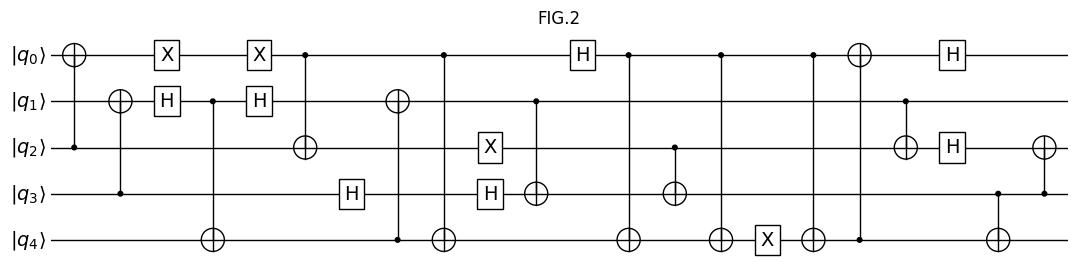

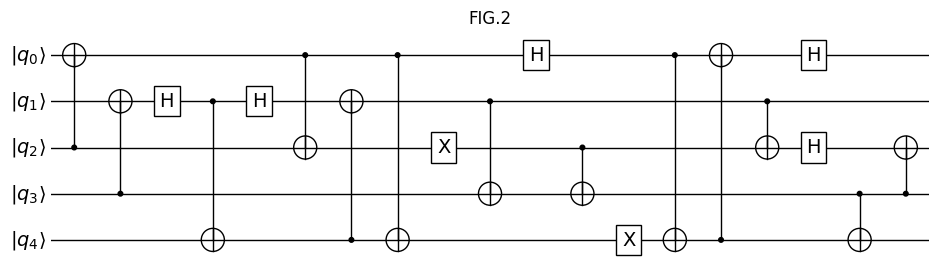

In [22]:
circuit = testing_circuit2()

ax, fig = plot_circuit(circuit)
ax.set_title("FIG.2")
plt.show()

opt_circuit = optimize_circuit(circuit)

ax, fig = plot_circuit(opt_circuit)
ax.set_title("FIG.2")
plt.show()

### TESTING EVERYTHING TOGETHER:

q0:     ─o─X─o─X─o─X─o─────X─o─X─o─X─o───X─o───X─o─X─o─X─o───X─o─X─o─X─o───H─X ...
q1:     ─X─|─|─|─|─|─|─────|─|─|─|─|─|─────|─H─|─|─|─|─|─|───o─X─o─|─|─|─o─X─| ...
q2:     ───|─|─|─|─|─|─────|─|─|─X─o─X─X───|───o─X─o─|─|─|─o───────X─o─X─X───| ...
q3:     ───|─|─|─X─o─X─X─H─o─X─o───────o─H─|─────────X─o─X─X─────────────────o ...
q4:     ───o─X─o───────o─X─────────────────X────────────────────────────────── ...

q0: ... ─o───X─o─X─o─X─o───X─o─X─o─X─o─X─o─────X─o─X─o─X─o───X─o─X─o─X─o───X─o ...
q1: ... ─|───|─|─|─|─|─|───|─|─o─X─o─|─|─|─o───|─|─|─|─|─|───|─|─|─X─o─X─X─o─X ...
q2: ... ─|───|─|─|─X─o─X─X─|─|───────X─o─X─X─X─|─|─|─X─o─X─X─o─X─o───────o──── ...
q3: ... ─X───|─|─|───────|─|─|─────────────────|─|─|───────|────────────────── ...
q4: ... ───H─o─X─o───────o─o─X─────────────────o─X─o───────o────────────────── ...

q0: ... ─X─o─X─o─────o─o─
q1: ... ─o─|─|─|─o───|─|─
q2: ... ───|─|─|─|─H─|─|─
q3: ... ───|─|─|─|───X─|─
q4: ... ───X─o─X─X─H───X─


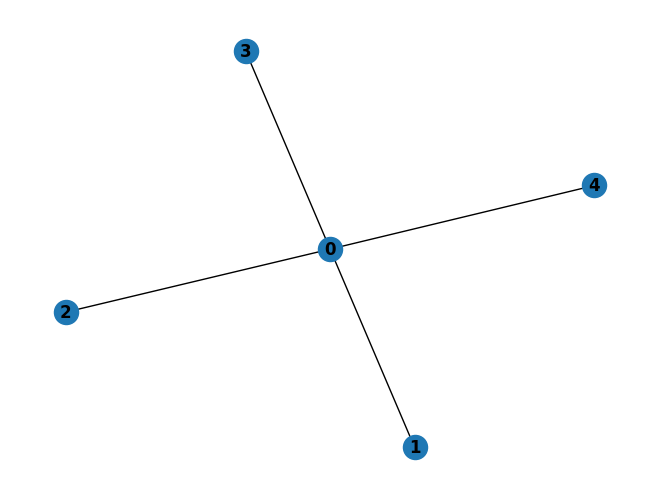

In [23]:
timesteps = generate_timesteps(circuit)
mapping = initial_mapping(timesteps)
non_optimized_circuit = routing(timesteps, mapping)
optimized_circuit = optimize_circuit(non_optimized_circuit)

print(optimized_circuit)

## Exercise 4 (More challenging)

First, a disclaimer, finding optimal qubit routing algorithms is an open-research question. If you made it through here, let us congratulate you, it was not an easy task! 

Can you think of another algorithm, that would also work, even if it is very simple or slow? Try and implement it! 

- How does it compare with the provided?

- What 2q gates depths do you get? Try different circuits!

## Exercise 5 (Truly challenging - research level)

In case anyone loved this challenge and would like to explore a continuation, we leave to you a possible extension of this problem with machine-learning. The main idea is expressed in this [paper](https://arxiv.org/abs/1812.11619), where the authors use Reinforcement Learning to learn optimal policies for qubit routing. Good luck!